Сперва скопируем уже готовые части кода из 3.ipynb для задания

# Импорт

In [3]:
!pip install jupyterlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.16.0
    Uninstalling jupyter-server-1.16.0:
      Successfully uninstalled jupyter-server-1.16.0
ERROR: pip's dependency resolver does not currently take into account all 

In [4]:
import os
import numpy as np
import torch
import polars as pl
import pandas as pd
import sklearn
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import jupyterlab as jlab
import ipywidgets
import random

from scipy.integrate import quad
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Часть 1

За основу был взят код из ноутбука 3

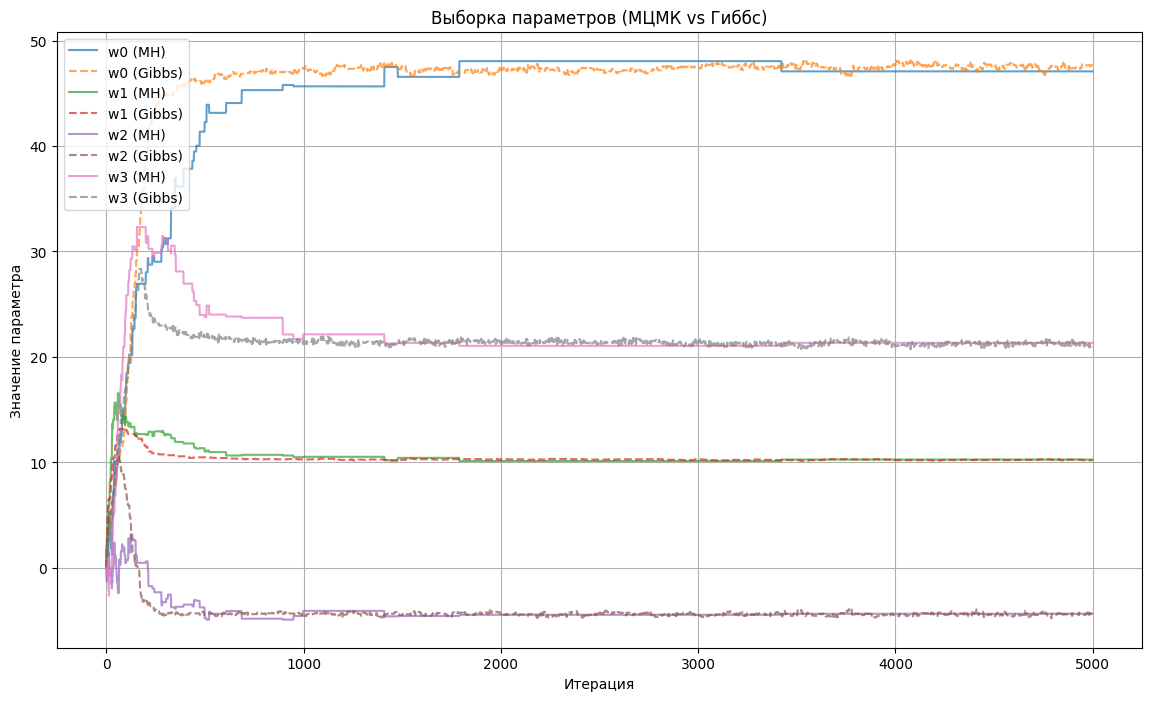

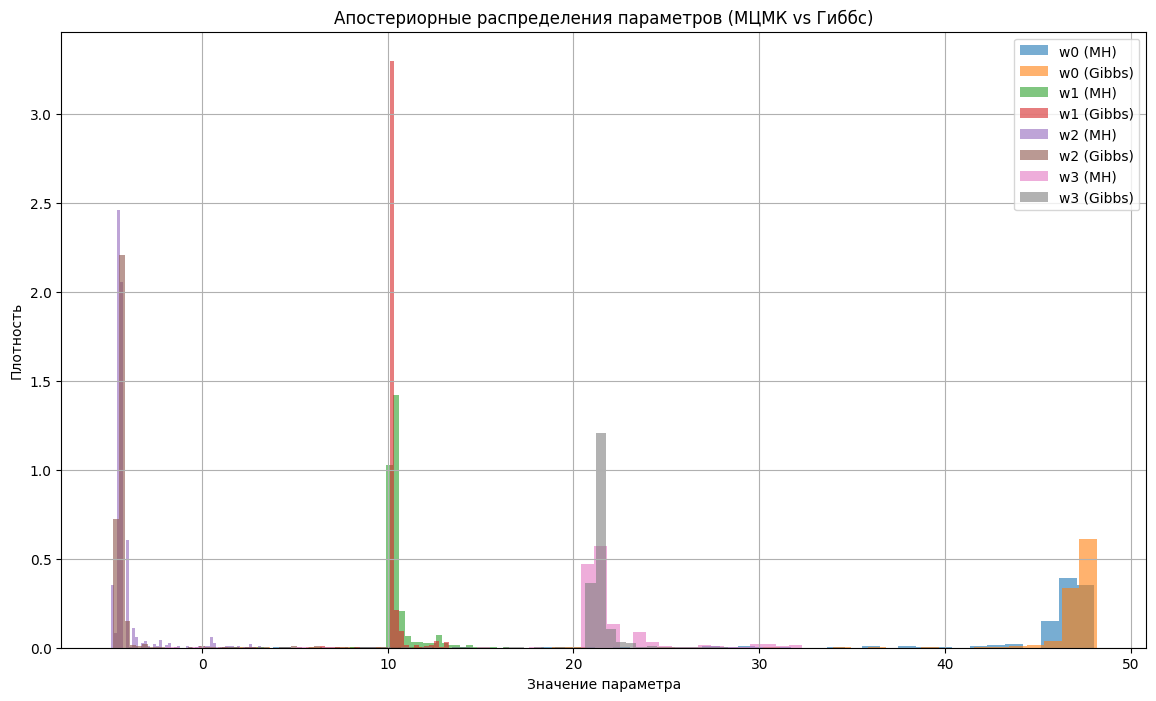

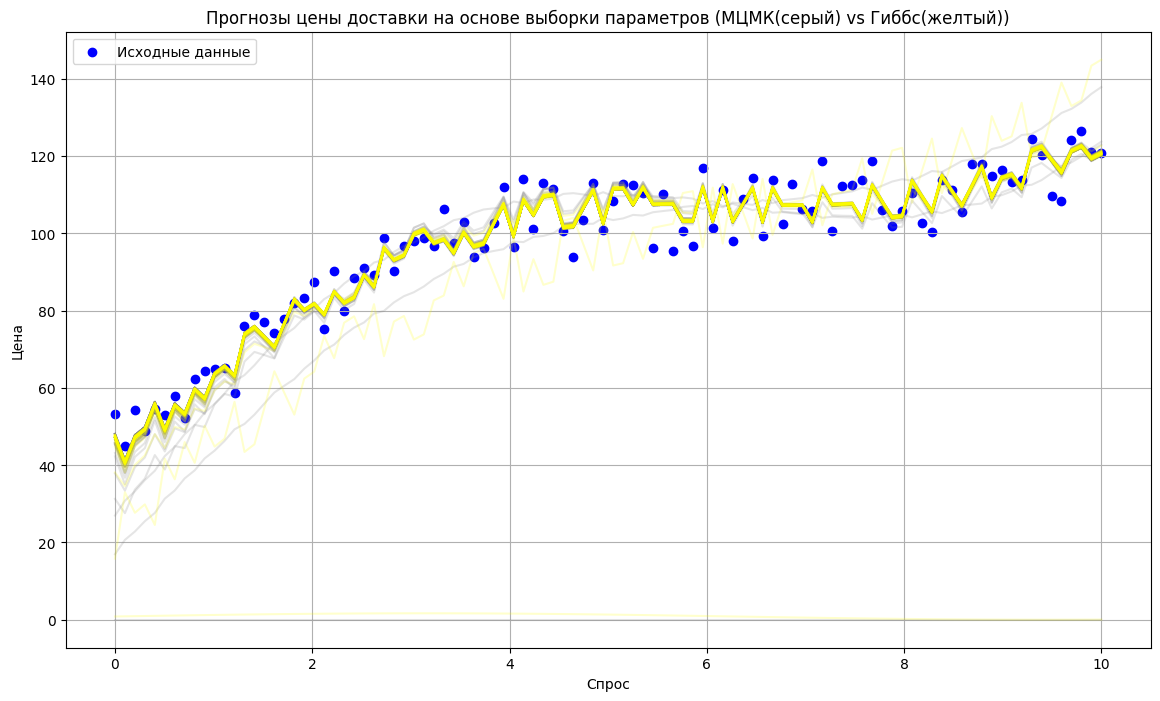

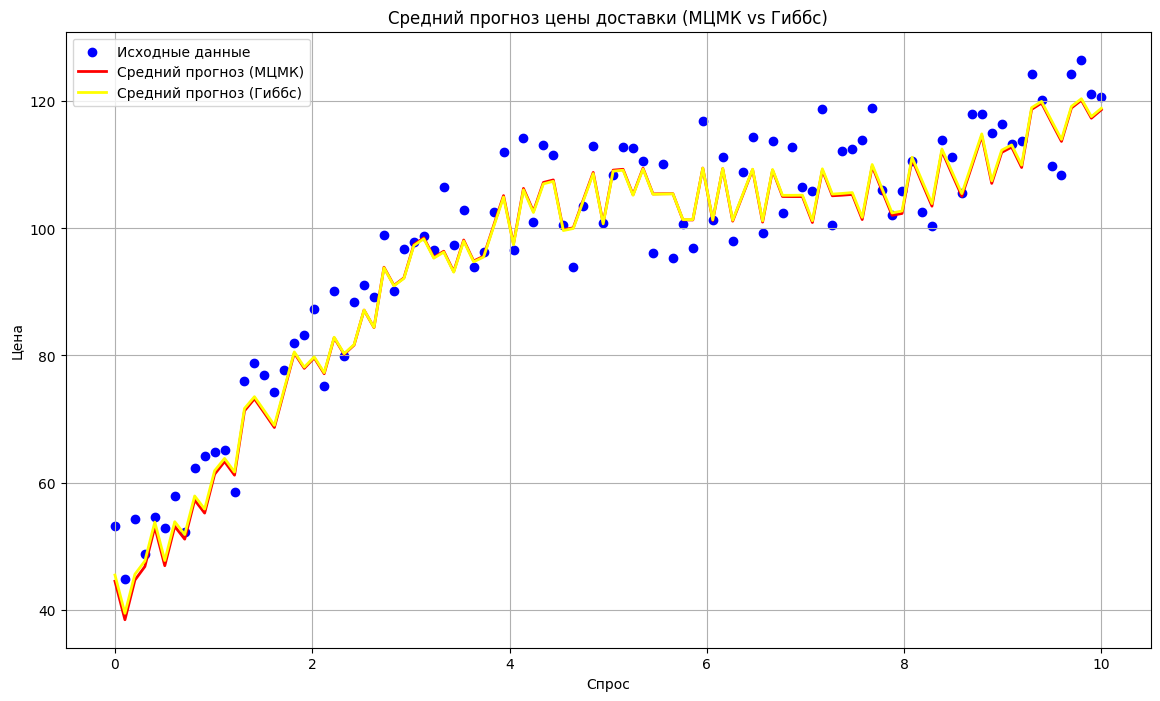

In [15]:
# Генерация синтетических данных
torch.manual_seed(42)
n_samples = 100
demand = torch.linspace(0, 10, n_samples) # Спрос
weather = torch.randint(0, 3, size = (n_samples,)) # Погодные условия: 0 - хорошая, 1 - дождь, 2 - снег
seasonality = torch.sin(demand / 2) # Сезонность

# Реальные параметры модели
true_params = torch.tensor([50.0, 10.0, -5.0, 20.0]) # w0, w1, w2, w3
noise = torch.normal(0, 5, size = (n_samples,)) # Шум
price = (
    true_params[0]
    + true_params[1] * demand
    + true_params[2] * weather
    + true_params[3] * seasonality
    + noise
)

# Логарифм функции правдоподобия
def log_likelihood(w):
    prediction = w[0] + w[1] * demand + w[2] * weather + w[3] * seasonality
    return -0.5 * torch.sum((price - prediction) ** 2)

# Логарифм априорного распределения
def log_prior(w):
    return -0.5 * torch.sum(w**2) # Стандартное нормальное распределение

# Целевая функция: логарифм апостериорного распределения
def log_posterior(w):
    return log_prior(w) + log_likelihood(w)

# Алгоритм Метрополиса-Хастингса
def metropolis_hastings(n_iterations = 5000, proposal_std = 1.0):
    samples = []
    w_curr = torch.zeros(4) # Инициализация параметров
    for i in range(n_iterations):
        w_prop = w_curr + torch.normal(0, proposal_std, size=w_curr.shape) # Предложение
        log_ratio = log_posterior(w_prop) - log_posterior(w_curr)
        if torch.log(torch.rand(1)) < log_ratio:
            w_curr = w_prop # Принимаем новое значение
        samples.append(w_curr.clone())
    return torch.stack(samples)

# Алгоритм Гиббса
def gibbs_sampler(n_iterations=5000, proposal_std=0.5):
    samples = []
    w = torch.zeros(4)

    for i in range(n_iterations):
        for j in range(4):
            w_prop = w.clone()
            w_prop[j] += torch.normal(0., proposal_std, size=()).item()
            log_ratio = log_posterior(w_prop) - log_posterior(w)
            if torch.log(torch.rand(1)) < log_ratio:
                w[j] = w_prop[j]
        samples.append(w.clone())

    return torch.stack(samples)

# Запуск
n_iterations = 5000
samples = metropolis_hastings(n_iterations = n_iterations)
samples_g = gibbs_sampler(n_iterations = n_iterations)

# Визуализация выборки параметров
param_names = ["w0", "w1", "w2", "w3"]
plt.figure(figsize = (14, 8))
for i in range(4):
    plt.plot(samples[:, i], label=f"{param_names[i]} (MH)", alpha=0.7)
    plt.plot(samples_g[:, i], label=f"{param_names[i]} (Gibbs)", linestyle='--', alpha=0.7)
plt.title("Выборка параметров (МЦМК vs Гиббс)")
plt.xlabel("Итерация")
plt.ylabel("Значение параметра")
plt.legend()
plt.grid()
plt.show()

# Апостериорные распределения параметров
plt.figure(figsize = (14, 8))
for i in range(4):
    plt.hist(samples[:, i].numpy(), bins = 50, alpha = 0.6, label = f"{param_names[i]} (MH)", density = True)
    plt.hist(samples_g[:, i].numpy(), bins = 50, alpha = 0.6, label = f"{param_names[i]} (Gibbs)", density = True)
plt.title("Апостериорные распределения параметров (МЦМК vs Гиббс)")
plt.xlabel("Значение параметра")
plt.ylabel("Плотность")
plt.legend()
plt.grid()
plt.show()

# Прогноз цены на основе выборки параметров
predictions = []
for sample in samples[::100]: # Каждая 100-я выборка
    pred = sample[0] + sample[1] * demand + sample[2] * weather + sample[3] * seasonality
    predictions.append(pred)

predictions_g = []
for sample in samples_g[::100]: # Каждая 100-я выборка
    pred = sample[0] + sample[1] * demand + sample[2] * weather + sample[3] * seasonality
    predictions_g.append(pred)

plt.figure(figsize = (14, 8))
for pred in predictions:
    plt.plot(demand, pred, color = "gray", alpha = 0.2)
plt.scatter(demand, price, color = "blue", label = "Исходные данные")

for pred in predictions_g:
    plt.plot(demand, pred, color = "yellow", alpha = 0.2)

plt.title("Прогнозы цены доставки на основе выборки параметров (МЦМК(серый) vs Гиббс(желтый))")
plt.xlabel("Спрос")
plt.ylabel("Цена")
plt.legend()
plt.grid()
plt.show()

# Средний прогноз
mean_prediction = torch.mean(torch.stack(predictions), dim = 0)
mean_prediction_g = torch.mean(torch.stack(predictions_g), dim = 0)

plt.figure(figsize = (14, 8))
plt.scatter(demand, price, color = "blue", label = "Исходные данные")
plt.plot(demand, mean_prediction, color = "red", label = "Средний прогноз (МЦМК)", linewidth = 2)
plt.plot(demand, mean_prediction_g, color = "yellow", label = "Средний прогноз (Гиббс)", linewidth = 2)
plt.title("Средний прогноз цены доставки (МЦМК vs Гиббс)")
plt.xlabel("Спрос")
plt.ylabel("Цена")
plt.legend()
plt.grid()
plt.show()

Оба метода дают индентичные результаты

# Часть 2

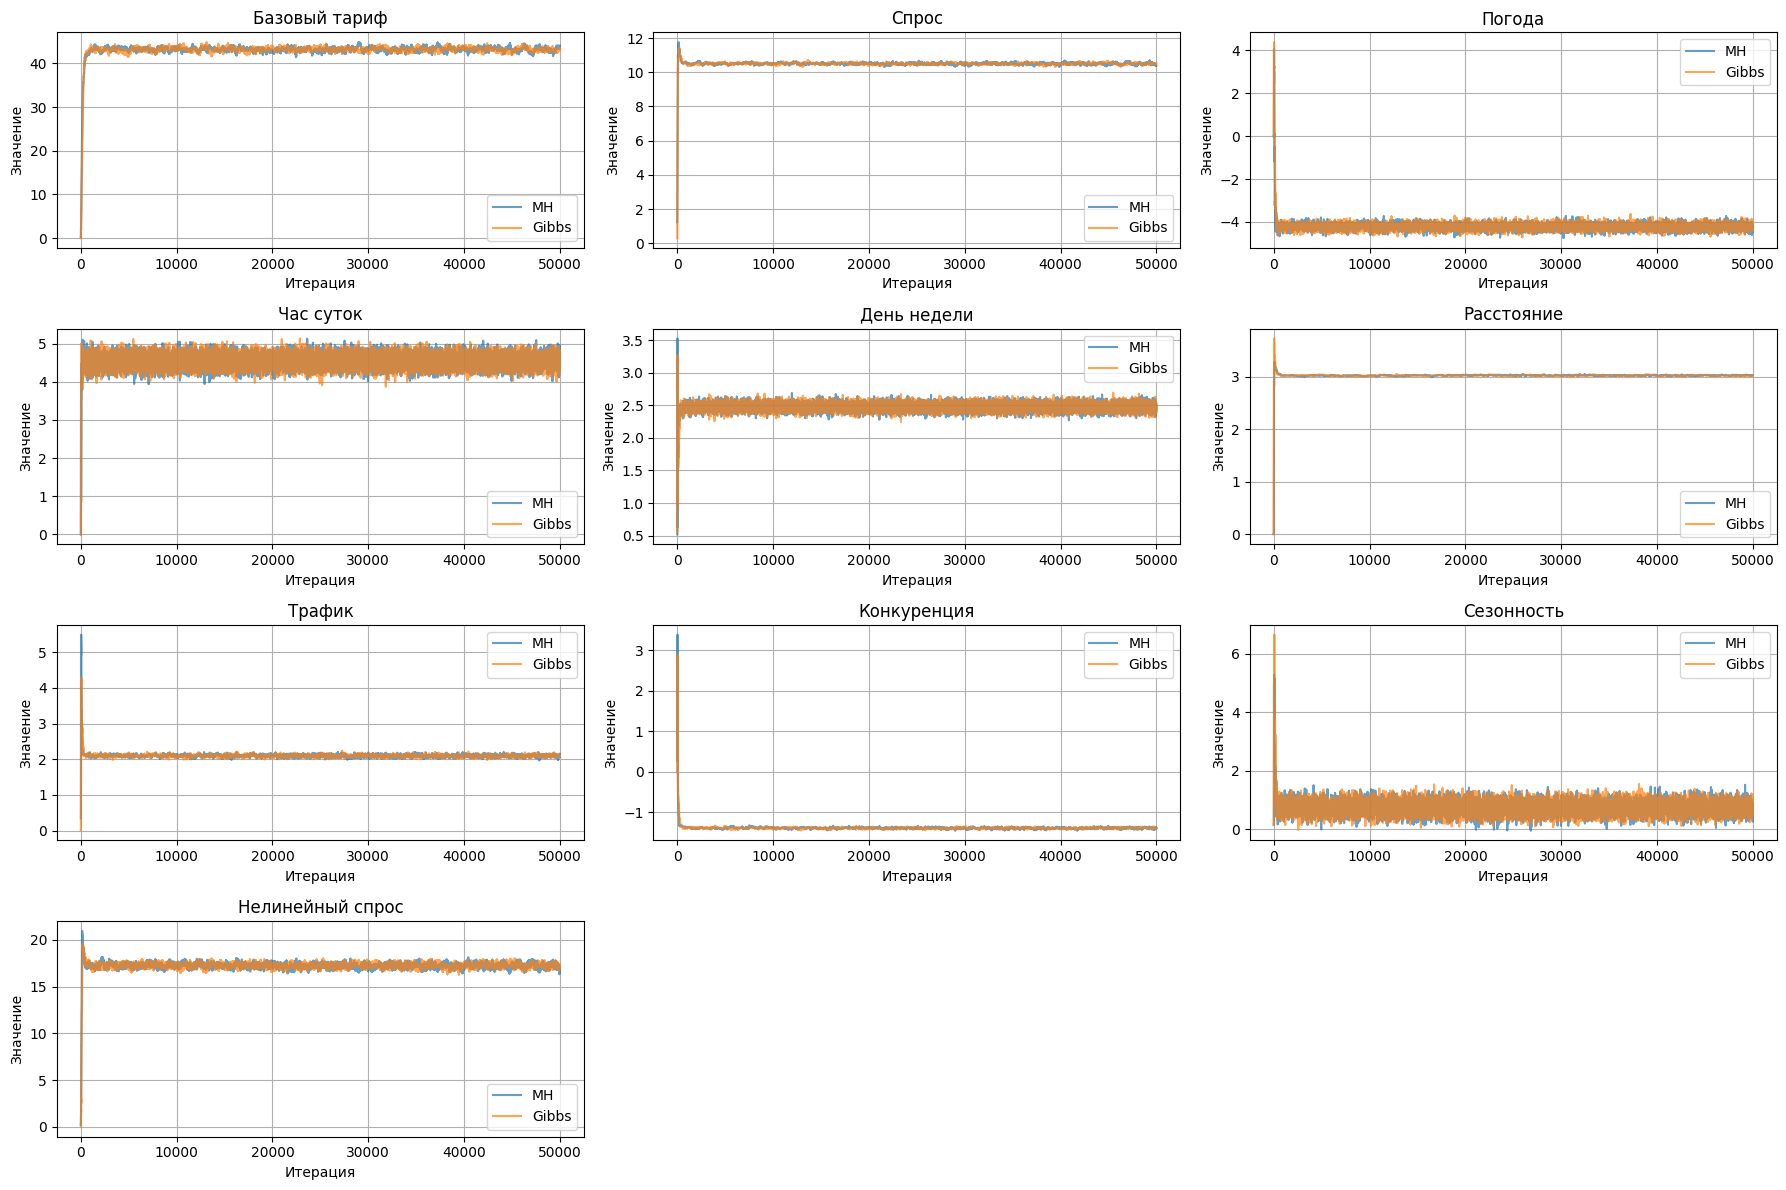

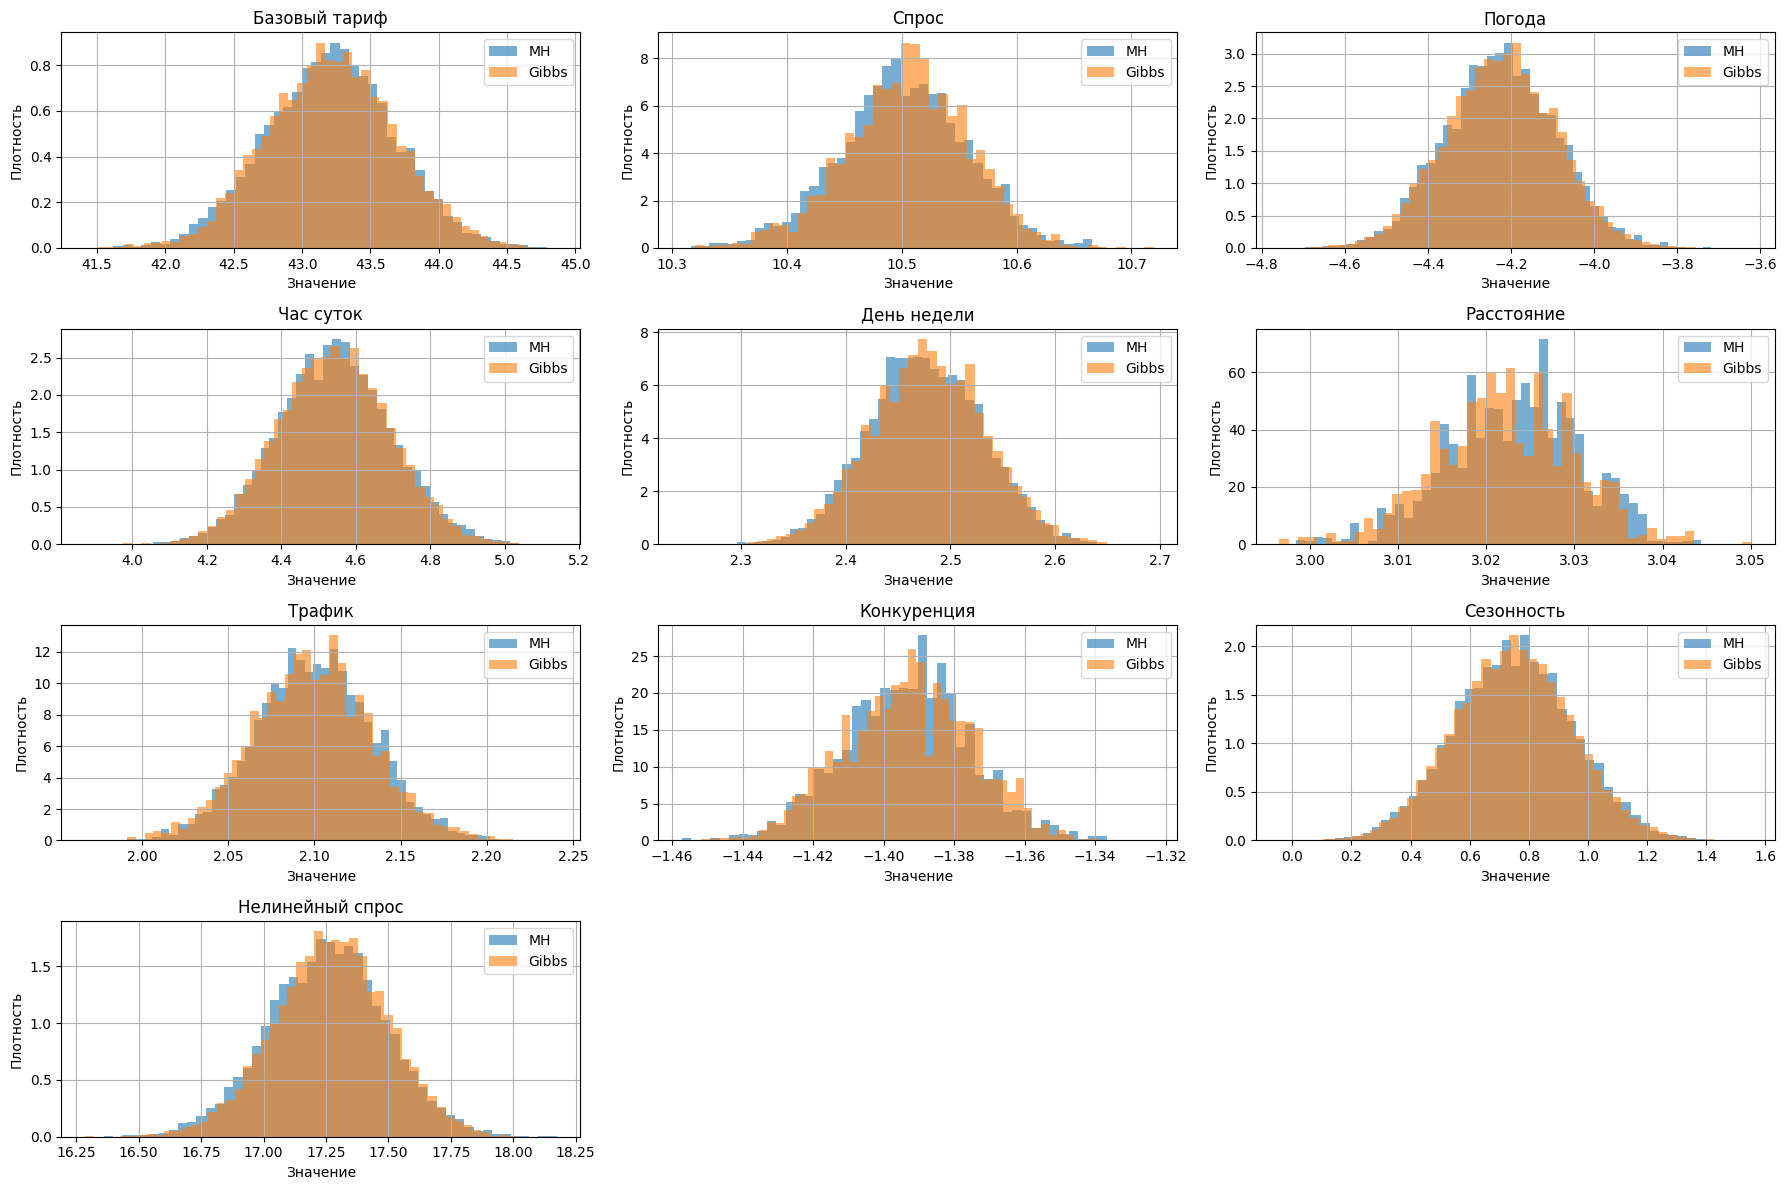

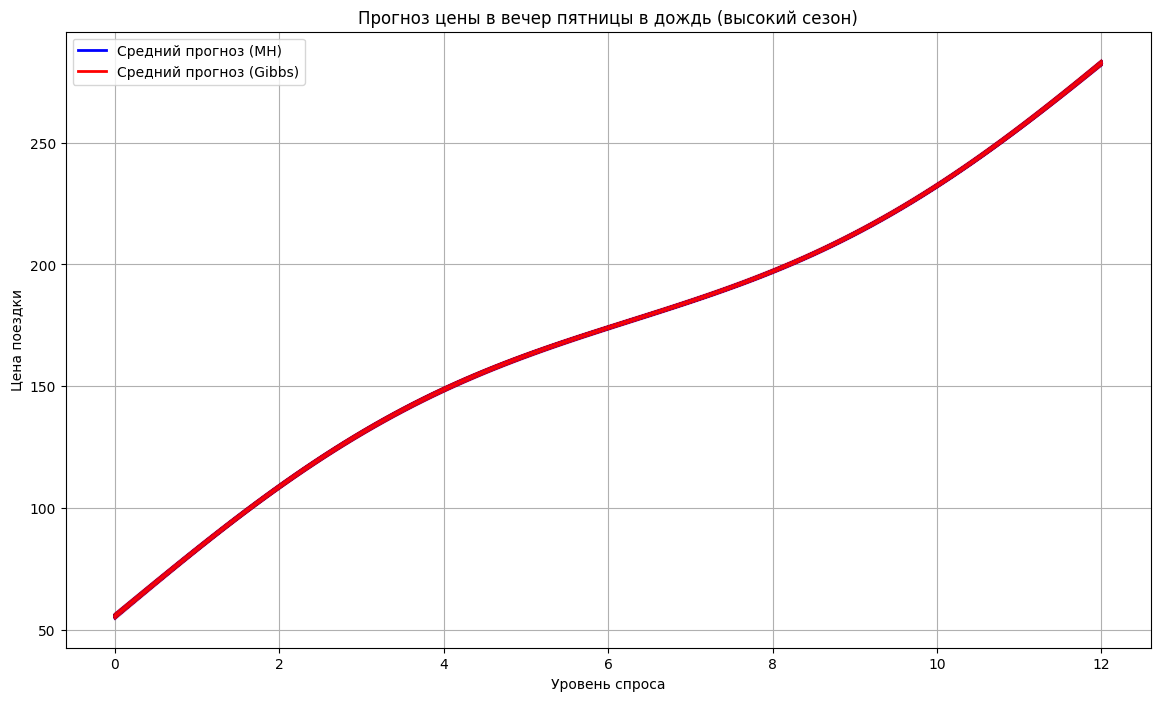

R-hat для MH: tensor([1.0013, 1.0004, 1.0033, 1.0084, 0.9999, 1.0052, 1.0042, 1.0014, 1.0011,
        1.0043])
R-hat для Gibbs: tensor([1.0004, 1.0025, 1.0011, 1.0069, 1.0024, 1.0051, 1.0012, 1.0002, 1.0060,
        1.0064])


In [22]:
# Генерация синтетических данных
torch.manual_seed(42)
n_samples = 100

# Генерация факторов
demand = torch.linspace(0, 10, n_samples)  # Спрос (нормализованный)
weather = torch.randint(0, 3, (n_samples,))  # Погода: 0-хорошая, 1-дождь, 2-снег
hour = torch.randint(0, 24, (n_samples,))  # Час суток (0-23)
weekday = torch.randint(1, 8, (n_samples,))  # День недели (1-7)
distance = torch.randint(1, 51, (n_samples,))  # Расстояние (1-50 км)
traffic = torch.randint(0, 11, (n_samples,))  # Плотность трафика (0-10)
competition = torch.randint(0, 21, (n_samples,))  # Конкуренция (0-20 машин в радиусе 1 км)
season = torch.randint(0, 2, (n_samples,))  # Сезонность (0-низкий, 1-высокий)

# Истинные параметры модели
true_params = torch.tensor([50.0, 10.0, -5.0, 3.0, 2.0, -1.5, -0.5, 15.0])

# Добавляем нелинейные эффекты для некоторых факторов
hour_effect = 5 * torch.sin(hour * 2 * np.pi / 24)
weekday_effect = 2 * (weekday - 4)  # Пик в середине недели

# Генерация цены с шумом
noise = torch.normal(0, 5, (n_samples,))
price = (
    true_params[0] +  # Базовый тариф
    true_params[1] * demand +  # Влияние спроса
    true_params[2] * weather +  # Влияние погоды
    hour_effect +  # Нелинейный эффект часа
    weekday_effect +  # Эффект дня недели
    true_params[3] * distance +  # Влияние расстояния
    true_params[4] * traffic +  # Влияние трафика
    true_params[5] * competition +  # Влияние конкуренции
    true_params[6] * season +  # Сезонность
    true_params[7] * torch.sin(demand / 2) +  # Нелинейный эффект спроса
    noise
)
# Хотя базовых факторов 8, добавлено 2 производных признака — sin(hour) и sin(demand/2) — чтобы учесть нелинейные зависимости.
# Это делает модель более реалистичной. В итоге анализируется 10 параметров, отражающих как линейные, так и нелинейные эффекты.
# Логарифм функции правдоподобия
def log_likelihood(w):
    prediction = (
        w[0] +  # Базовый тариф
        w[1] * demand +  # Спрос
        w[2] * weather +  # Погода
        w[3] * torch.sin(hour * 2 * np.pi / 24) +  # Час суток
        w[4] * (weekday - 4) +  # День недели
        w[5] * distance +  # Расстояние
        w[6] * traffic +  # Трафик
        w[7] * competition +  # Конкуренция
        w[8] * season +  # Сезонность
        w[9] * torch.sin(demand / 2)  # Нелинейный эффект спроса
    )
    return -0.5 * torch.sum((price - prediction) ** 2)

# Логарифм априорного распределения (нормальное распределение)
def log_prior(w):
    return -0.5 * torch.sum(w**2)

# Логарифм апостериорного распределения
def log_posterior(w):
    return log_prior(w) + log_likelihood(w)

# Алгоритм Метрополиса-Хастингса для 10 параметров
# Алгоритм улучшен добавлением адаптивным измененем std, поскольку обычный алгоритм при общх параметрах сходился не во всех случаях, требовался аккуратный тюнинг
# Отдельно следует отметить, что алгоритм Гиббса в текущих условиях задачи в таких манипуляциях не нуждается и сходится без сложностей
def metropolis_hastings(n_iterations=20000, initial_std=0.5, adapt_interval=500, target_acceptance=0.3):
    dim = 10
    samples = []
    w_curr = torch.zeros(dim)
    proposal_std = torch.ones(dim) * initial_std
    accepted = torch.zeros(dim)

    for i in range(n_iterations):
        for j in range(dim):
            w_prop = w_curr.clone()
            w_prop[j] += torch.normal(0, proposal_std[j], size=())
            log_ratio = log_posterior(w_prop) - log_posterior(w_curr)
            if torch.log(torch.rand(1)) < log_ratio:
                w_curr[j] = w_prop[j]
                accepted[j] += 1
        samples.append(w_curr.clone())

        # адаптация std каждые adapt_interval итераций
        if (i + 1) % adapt_interval == 0 and i < n_iterations // 2:
            acc_rate = accepted / adapt_interval
            proposal_std *= torch.exp(0.1 * (acc_rate - target_acceptance))  # шаг адаптации
            accepted = torch.zeros(dim)  # сброс
    return torch.stack(samples)


# Алгоритм Гиббса для 10 параметров
def gibbs_sampler(n_iterations=10000, proposal_std=0.3):
    samples = []
    w = torch.zeros(10)

    for i in range(n_iterations):
        for j in range(10):
            w_prop = w.clone()
            w_prop[j] += torch.normal(0., proposal_std, size=()).item()
            log_ratio = log_posterior(w_prop) - log_posterior(w)
            if torch.log(torch.rand(1)) < log_ratio:
                w[j] = w_prop[j]
        samples.append(w.clone())

    return torch.stack(samples)

# Запуск алгоритмов
n_iterations = 50000
samples_mh = metropolis_hastings(n_iterations=n_iterations)
samples_gibbs = gibbs_sampler(n_iterations=n_iterations)

# Визуализация результатов
param_names = [
    "Базовый тариф", "Спрос", "Погода", "Час суток",
    "День недели", "Расстояние", "Трафик",
    "Конкуренция", "Сезонность", "Нелинейный спрос"
]

# Траектории параметров
plt.figure(figsize=(18, 12))
for i in range(10):
    plt.subplot(4, 3, i+1)
    plt.plot(samples_mh[:, i], label="MH", alpha=0.7)
    plt.plot(samples_gibbs[:, i], label="Gibbs", alpha=0.7)
    plt.title(param_names[i])
    plt.xlabel("Итерация")
    plt.ylabel("Значение")
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

# Апостериорные распределения
plt.figure(figsize=(18, 12))
for i in range(10):
    plt.subplot(4, 3, i+1)
    plt.hist(samples_mh[2000:, i].numpy(), bins=50, alpha=0.6, label="MH", density=True)
    plt.hist(samples_gibbs[2000:, i].numpy(), bins=50, alpha=0.6, label="Gibbs", density=True)
    plt.title(param_names[i])
    plt.xlabel("Значение")
    plt.ylabel("Плотность")
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

# Прогнозы на новых данных
# Генерация новых данных для прогноза
new_demand = torch.linspace(0, 12, 100)
new_hour = torch.full((100,), 18)  # Вечерний час пик
new_weekday = torch.full((100,), 5)  # Пятница
new_weather = torch.full((100,), 1)  # Дождь
new_distance = torch.linspace(5, 40, 100)
new_traffic = torch.full((100,), 8)  # Высокий трафик
new_competition = torch.full((100,), 10)  # Средняя конкуренция
new_season = torch.full((100,), 1)  # Высокий сезон

# Прогнозы с MH
predictions_mh = []
for sample in samples_mh[2000::50]:  # Берем каждую 50-ю выборку после burn-in
    pred = (
        sample[0] +
        sample[1] * new_demand +
        sample[2] * new_weather +
        sample[3] * torch.sin(new_hour * 2 * np.pi / 24) +
        sample[4] * (new_weekday - 4) +
        sample[5] * new_distance +
        sample[6] * new_traffic +
        sample[7] * new_competition +
        sample[8] * new_season +
        sample[9] * torch.sin(new_demand / 2)
    )
    predictions_mh.append(pred)

# Прогнозы с Gibbs
predictions_gibbs = []
for sample in samples_gibbs[2000::50]:
    pred = (
        sample[0] +
        sample[1] * new_demand +
        sample[2] * new_weather +
        sample[3] * torch.sin(new_hour * 2 * np.pi / 24) +
        sample[4] * (new_weekday - 4) +
        sample[5] * new_distance +
        sample[6] * new_traffic +
        sample[7] * new_competition +
        sample[8] * new_season +
        sample[9] * torch.sin(new_demand / 2)
    )
    predictions_gibbs.append(pred)

# Визуализация прогнозов
plt.figure(figsize=(14, 8))
for pred in predictions_mh:
    plt.plot(new_demand, pred, color='blue', alpha=0.05)
for pred in predictions_gibbs:
    plt.plot(new_demand, pred, color='red', alpha=0.05)

# Средние прогнозы
mean_pred_mh = torch.mean(torch.stack(predictions_mh), dim=0)
mean_pred_gibbs = torch.mean(torch.stack(predictions_gibbs), dim=0)

plt.plot(new_demand, mean_pred_mh, color='blue', linewidth=2, label='Средний прогноз (MH)')
plt.plot(new_demand, mean_pred_gibbs, color='red', linewidth=2, label='Средний прогноз (Gibbs)')
plt.title("Прогноз цены в вечер пятницы в дождь (высокий сезон)")
plt.xlabel("Уровень спроса")
plt.ylabel("Цена поездки")
plt.legend()
plt.grid()
plt.show()

# Анализ сходимости
# Вычисление R-hat (показатель сходимости)
def r_hat(chains):
    m = chains.shape[0]  # количество цепей
    n = chains.shape[1]  # количество выборок в каждой цепи

    chain_means = torch.mean(chains, dim=1)  # среднее по каждой цепи
    chain_vars = torch.var(chains, dim=1, unbiased=True)  # дисперсия по каждой цепи
    W = torch.mean(chain_vars, dim=0)  # средняя внутрицепная дисперсия

    # Межцепная дисперсия
    overall_mean = torch.mean(chain_means, dim=0)
    B = n * torch.var(chain_means, dim=0, unbiased=True)

    # Оценка дисперсии
    var_plus = (n - 1)/n * W + 1/n * B
    rhat = torch.sqrt(var_plus / W)
    return rhat

# Запуск нескольких цепей для оценки R-hat
n_chains = 4
chains_mh = []
chains_gibbs = []

for _ in range(n_chains):
    chains_mh.append(metropolis_hastings(n_iterations=2000))
    chains_gibbs.append(gibbs_sampler(n_iterations=2000))

chains_mh = torch.stack(chains_mh)
chains_gibbs = torch.stack(chains_gibbs)

rhat_mh = r_hat(chains_mh)
rhat_gibbs = r_hat(chains_gibbs)

print("R-hat для MH:", rhat_mh)
print("R-hat для Gibbs:", rhat_gibbs)

Первая группа изображений трейсы параметров (графики по итерациям).

Gibbs и MH сравниваются по 10 параметрам. По большинству параметров оба метода хорошо сходятся к стационарному распределению. Однако:

-- У MH для параметров "Базовый тариф", "Конкуренция", "Сезонность", и особенно "Расстояние" наблюдается более медленная сходимость, большая дисперсия, колебания на трейсе, особенно в начале.

-- У Gibbs почти идеальные трейсы: быстрый выход на стационар и стабильное поведение. Графики показывают, как значения параметров меняются в процессе работы алгоритмов. Видно, что после периода "прогрева" (burn-in) параметры стабилизируются вокруг некоторых значений.

Вторая группа -- гистограммы апостериорного распределения. Они демонстрируют распределение значений параметров после сходимости. Обе выборки (MH и Gibbs) дают очень похожие формы распределений. Однако:

-- У обоих методов по параметру "Расстояние" плотность явно "зазубрена", то есть возможны автокоррелированные сэмплы или низкая эффективность.

-- Для остальных параметров различия минимальны, формы распределений почти совпадают.

На графике прогнозов (последний из графиков) видно, как цена зависит от спроса в заданных условиях (например, вечер пятницы, дождь, высокий сезон). Красная линия и синяя - средний прогноз для методов.

Показатель R-hat близок к 1 для обоих алгоритмов, что указывает на хорошую сходимость.

Алгоритм Гиббса даёт быструю сходимость по всем параметрам, гладкие, стабильные траектории. R-hat близки к 1 (≈1.000–1.002), что говорит о хорошей сходимости.

Алгоритм Метрополиса-Хастингса с учетом улучшений также быстро сходится. Но распределения в отдельных случаях могут иметь более широкие хвосты или нестабильную форму.

MH зависит от выбора масштаба предложения (proposal std), тогда как Гиббс — от частичной условной структуры, что делает его более стабильным, особенно при слабой корреляции между параметрами.

Гиббс-семплирование эффективнее по времени сходимости в данной задаче в большинстве ситуаций, особенно если сравнивать с обычной версией алгоритма MH.Гиббс обновляет каждый параметр по отдельности (условные распределения), что снижает "отскоки". Метрополис-Хастингс в классическом варианте может застревать в высокоразмерных пространствах и требует ручного подбора proposal_std или автоподбора.

В рамках блочного Гиббса использование диагональных (или адаптивных) ковариационных матриц оправдано и может ускорить сходимость.

Регуляризация помогает стабилизировать апостериорное распределение, особенно при коррелированных или мультиколлинеарных факторах.

Если использовать жёсткое априорное распределение (например, N(0, 1)), то оно может сильно ограничивать параметры, особенно при малом шуме или высокой размерности. Регуляризация в виде слабого априорного распределения позволяет избежать переограничения. Также можно использовать лаприское распределение (L1-регуляризация) для индукции разреженности (если часть коэффициентов может быть нулевыми).